In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

In [2]:
def calc_height(t, p, jump = True):
    '''
    isotherm height formular
    z = -R*t0/g * ln(p/p0)
    z = -287.053*t0/9.80665 * ln(p/p0)
    
    polytrop height forumular
    z = t0/L * ((p/p0)**(-L*R/g) -1)
    L = −0.0065 K/m
    R = 287.053 J/(kg K)
    g = 9.80665 m/s2
    z = t0/−0.0065 * ((p/p0)**(0.0065*287.053/9.80665) -1)
    
    international height formular
    z = 288.15/0.0065 * (1- (p/1013.25)**(1/5.255))
    
    '''
    # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
    SHR_CONST_AVOGAD  = 6.02214e26
    SHR_CONST_BOLTZ   = 1.38065e-23
    SHR_CONST_MWDAIR  = 28.966
    SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
    SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
    rair = SHR_CONST_RDAIR

    SHR_CONST_G       = 9.80616
    gravit = SHR_CONST_G

    SHR_CONST_CPDAIR  = 1.00464e3
    cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
    cnst_kap = cappa

    cnst_faktor = -gravit/rair
    cnst_ka1    = cnst_kap - 1.
        
    z = []
    for i in range(len(t)):
        
        if i == 0:
            L = -0.0065
            height = t[i]/L * ((p[i]/101325)**(-L*287.053/9.80665) -1)
            z.append(height)
        else:
            if jump:
                if z[i-1] < 11000:
                    L = -0.0065
                else:
                    L = -0.001
            else:                    
                # dt/dz
                pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
                pm = pmk**(1/cnst_kap)               
                a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
                b = t[i]-(a*p[i]**cnst_kap)
                tm = a * pmk + b               
                dtdp = a * cnst_kap * (pm**cnst_ka1)
                L = cnst_faktor*dtdp*pm/tm # dtdz
#                 if not ((L < 0.05) and (L > -0.05)):
#                     L = -0.0065
                if L == 0:
                    L = -0.001

            height = t[i-1]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)
            if np.isnan(height):
                print('p: ', p[i])
                print('p-1: ', p[i-1])
                print('t: ', t[i])
                print('t-1: ', t[i-1])
                print('L: ', L)
                z.append(z[-1])
            else:
                z.append(z[-1] + height)
    return z




        

# to gpm
from scipy.integrate import quad

def integrand(x):
    return (6371000 / (6371000 + x))**2
def expint(x):
    return quad(integrand, 0, x,)[0]


In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = numpy.radians(lon1)
    lat1 = numpy.radians(lat1)
    lon2 = numpy.radians(lon2)
    lat2 = numpy.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [4]:
def inverse_haversine(lat, lon, distance, direction):
    '''
    distance: [km]
    '''
    lat = numpy.radians(lat)
    lon = numpy.radians(lon)
    d = numpy.array(distance)
    r = 6371 #[km]
    if direction == "NORTH":
        brng = 0.
    elif direction == "EAST":
        brng = 1.5707963267948966
    else:
        return "error - not a valid direction"
    return_lat = numpy.arcsin(numpy.sin(lat) * numpy.cos(d / r) + numpy.cos(lat) * numpy.sin(d / r) * numpy.cos(brng))
    return_lon = lon + numpy.arctan2(numpy.sin(brng) * numpy.sin(d / r) * numpy.cos(lat), numpy.cos(d / r) - numpy.sin(lat) * numpy.sin(return_lat))

    return numpy.degrees(return_lat), numpy.degrees(return_lon)

In [5]:
# from haversine import inverse_haversine, Direction
def transport(lat, lon, u_dist, v_dist):
    '''
    dist: [km]
    '''
    new_lat, new_lon = inverse_haversine(lat, lon, u_dist, "EAST")
    new_lat, new_lon = inverse_haversine(new_lat, new_lon, v_dist, "NORTH")
    return new_lat, new_lon

In [6]:
def trajectory(lat, lon, u, v, pressure, temperature, w_rs = 5.0, wind = 'mean', factor = 1, u_factor = None, v_factor = None, z_variant = 'jump'):
    '''
    w_rs -> radio sonde rising speed
    '''
    if ((u_factor == None) and (v_factor == None)):
        u_factor = factor
        v_factor = factor
    
    if z_variant == 'jump':
        z = calc_height(temperature, pressure, jump = True) # m from K and Pa
    elif z_variant == 'ucar': 
        z = calc_height(temperature, pressure, jump = False) # m from K and Pa
#     print(temperature, pressure)
#     vec_expint = numpy.vectorize(expint)
#     z = vec_expint(z)
    
    lat_displacement = [0.]
    lon_displacement = [0.]
    
    for i in range(len(z)):
        if i == 0:
            new_lat = lat
            new_lon = lon
        else:
            rising_time = (z[i]-z[i-1]) / w_rs
#             print(z[i], z[i-1], z[i]-z[i-1], rising_time)
            status = 400
#             match wind:
#                 case 'mean':
#                     new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000., (np.mean([v[i],v[i-1]]) * rising_time)/1000.)
#                 case 'upper':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000., (v[i] * rising_time)/1000.)
#                 case 'lower':
#                     new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000., (v[i-1] * rising_time)/1000.) 
#                 case _:
#                     print('error: not a valid wind request')
            if wind == 'mean':
                new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000. * u_factor, (np.mean([v[i],v[i-1]]) * rising_time)/1000. * v_factor)
            elif wind == 'upper':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000. * u_factor, (v[i] * rising_time)/1000. * v_factor)
            elif wind == 'lower':
                new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000. * u_factor, (v[i-1] * rising_time)/1000. * v_factor) 
            else:
                print('error: not a valid wind request')


            
            lat_displacement.append(lon - new_lon)
            lon_displacement.append(lat - new_lat)
#         lat_displacement.append(new_lat)
#         lon_displacement.append(new_lon)

    return lat_displacement, lon_displacement


---
---
---

In [7]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
bufrfile = sodblist[0]

In [8]:
f = open(bufrfile)

In [9]:
bufr = codes_bufr_new_from_file(f)

# Different factors for wind to distance calculation - different for u and v

In [16]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_1={}
    rms_sum_lat_1={}
    rms_sum_lon_2={}
    rms_sum_lat_2={}
    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_1[i] = []
        rms_sum_lat_1[i] = []
        rms_sum_lon_2[i] = []
        rms_sum_lat_2[i] = []
        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            data = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
        if cont:
            if data.pressure[0] < 40000:
                u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                data['u'] = u
                v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                data['v'] = v
                data = data[data.airTemperature < 350]
                data = data[data.airTemperature > 180]
                data = data.drop_duplicates(['pressure'])
                
                true_latd = data.latitudeDisplacement
                true_lond = data.longitudeDisplacement

                print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                
                lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1)
                lat_displacement_test1, lon_displacement_test1 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', u_factor=0.83, v_factor = 1.15)
                statlat = np.array([data.lat.iloc[0]]*len(lat_displacement_100))
                statlon = np.array([data.lon.iloc[0]]*len(lon_displacement_100))
                dist_true = haversine(statlon, statlat, statlon + np.array(true_lond), statlat + np.array(true_latd))
                dist_100 = haversine(statlon, statlat, statlon + np.array(lon_displacement_100), statlat + np.array(lat_displacement_100))
                dist_test1 = haversine(statlon, statlat, statlon + np.array(lon_displacement_test1), statlat + np.array(lat_displacement_test1))
    
                fig, ax1 = maplt.subplots()
                ax1.plot(data.pressure,np.array(dist_100),color = 'red', label='calc distance 100')
                ax1.plot(data.pressure,np.array(dist_test1),color = 'blue', label='calc distance test1')
                ax1.plot(data.pressure,np.array(dist_true),color = 'green', alpha = 0.7, label='original distance')
                ax1.set_xlabel('pressure (Pa)')
                ax1.set_ylabel('distance (km)')
                ax1.tick_params(axis='y')
                ax1.legend()
                ax1.grid()
                ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
#                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
                ax2.plot(data.pressure,np.array(dist_100) - np.array(dist_true), color = 'red', linestyle = 'dotted', alpha = 0.3, label='diff 100')
                ax2.plot(data.pressure,np.array(dist_test1) - np.array(dist_true), color = 'blue', linestyle = 'dotted', alpha = 0.3, label='diff test1')
                ax2.set_ylabel('distance difference (km)')  # we already handled the x-label with ax1
                ax2.tick_params(axis='y',)
#                 ax2.legend()
#                 ax2.grid()
                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('distance')
                
                maplt.show()
                maplt.close()
                print('----------------')
                
                bc += 1
#         except:
#             pass
        if bc > 30:
            break
            
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
43.06 -108.48 19201130.0 230100.0


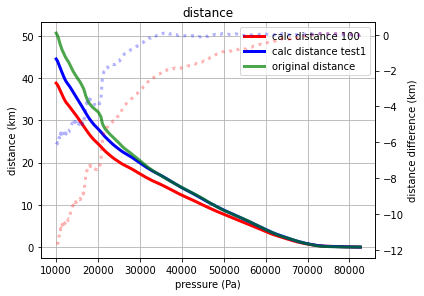

----------------
35.040000000000006 -106.62 19201130.0 230300.0


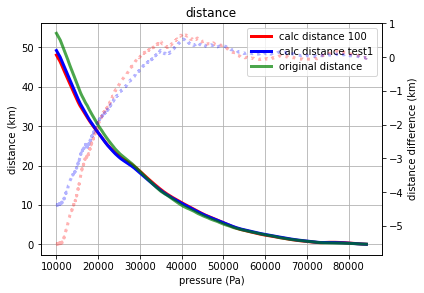

----------------
37.760000000000005 -99.97000000000001 19201130.0 230100.0


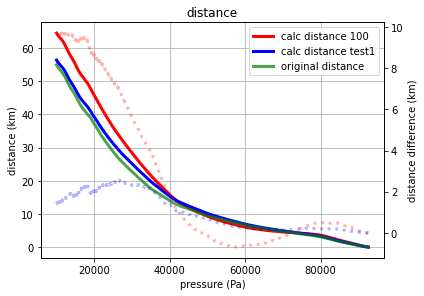

----------------
40.86000000000001 -115.74000000000001 19201130.0 230300.0


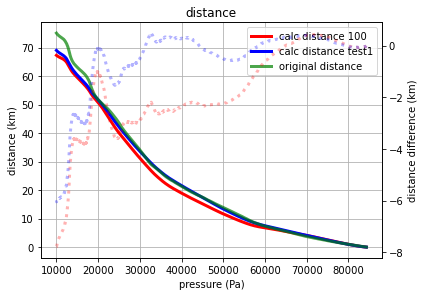

----------------
39.120000000000005 -108.53000000000002 19201130.0 230100.0


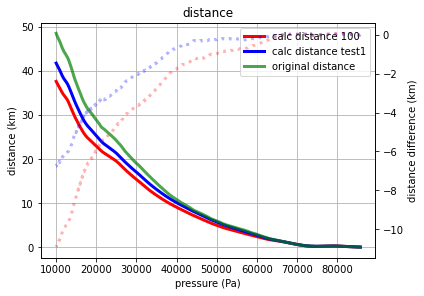

----------------
39.42 -83.82000000000001 19201130.0 230500.0


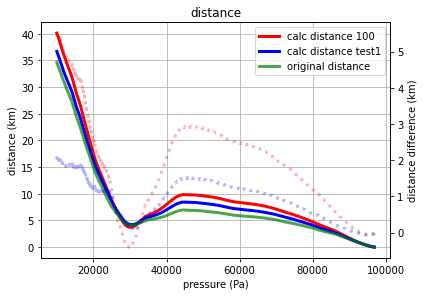

----------------
40.150000000000006 -89.34 19201130.0 230100.0


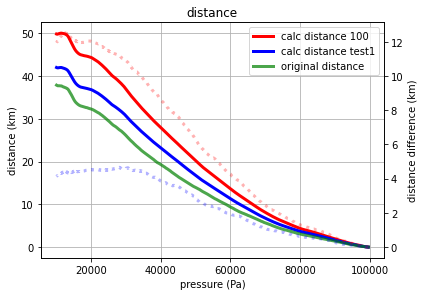

----------------
13.48 144.79000000000002 19201130.0 230100.0


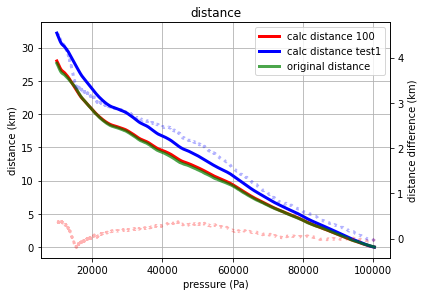

----------------
40.53 -80.22000000000001 19201130.0 230800.0


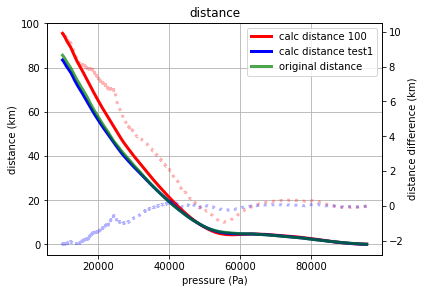

----------------
27.71 -82.4 19201130.0 230300.0


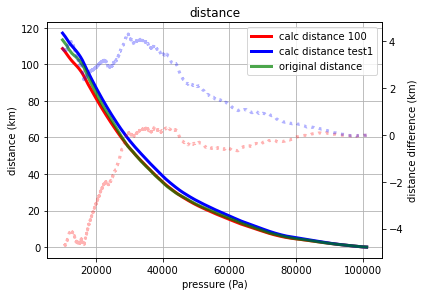

----------------
34.84 -92.26 19201130.0 231100.0


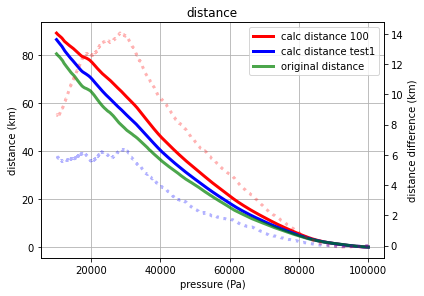

----------------
36.25 -86.56 19201130.0 230700.0


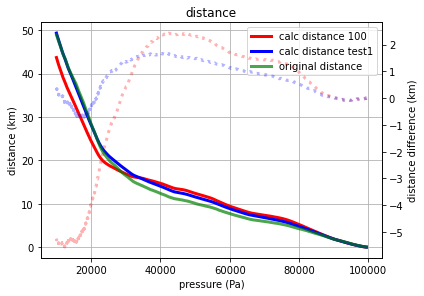

----------------
35.230000000000004 -101.71000000000001 19201130.0 230600.0


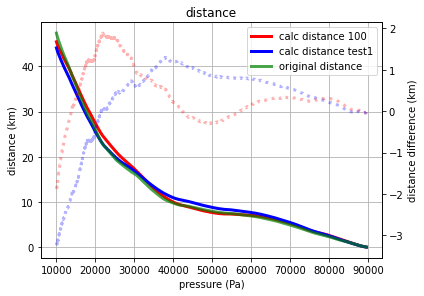

----------------
47.68000000000001 -117.63000000000001 19201130.0 230400.0


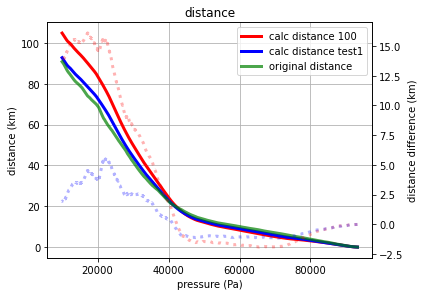

----------------
42.940000000000005 -78.72000000000001 19201130.0 231300.0


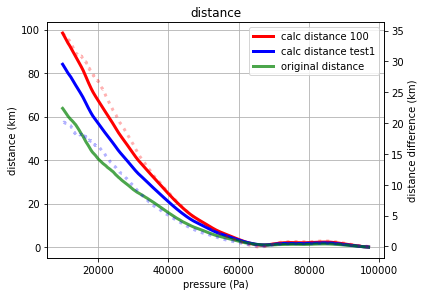

----------------
27.78 -97.51 19201130.0 230800.0


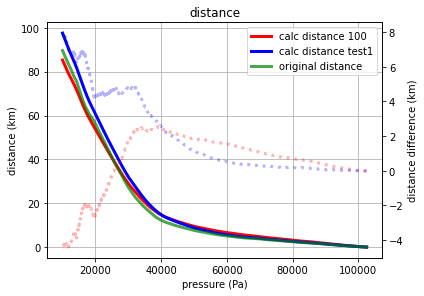

----------------
31.94 -102.19000000000001 19201130.0 230300.0


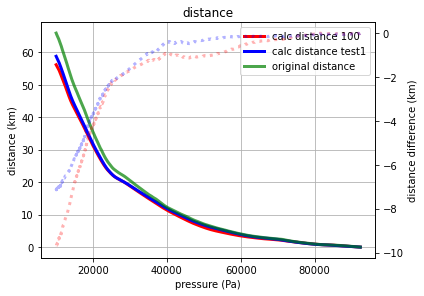

----------------
32.32 -90.08000000000001 19201130.0 230600.0


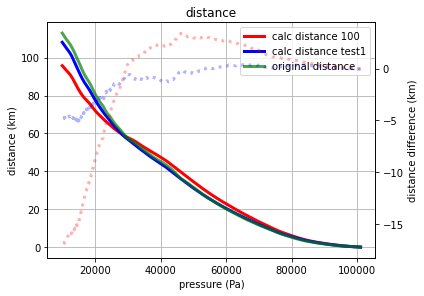

----------------
44.85 -93.56 19201130.0 230300.0


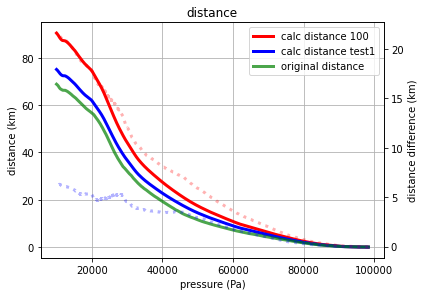

----------------
19.720000000000002 -155.06 19201130.0 230300.0


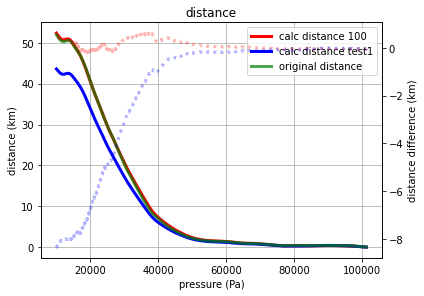

----------------
32.900000000000006 -80.03 19201130.0 230600.0


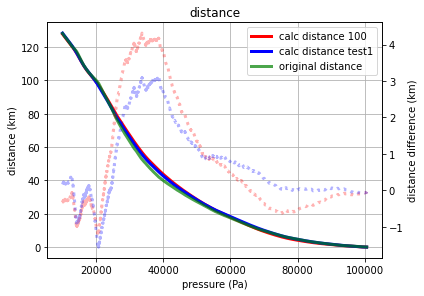

----------------
44.07 -103.21000000000001 19201130.0 230600.0


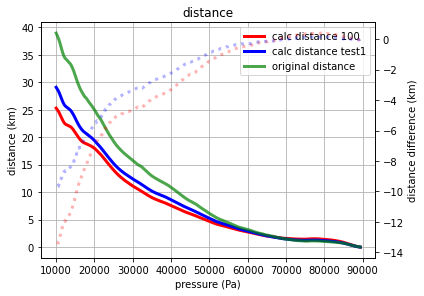

----------------
41.32 -96.37 19201130.0 231100.0


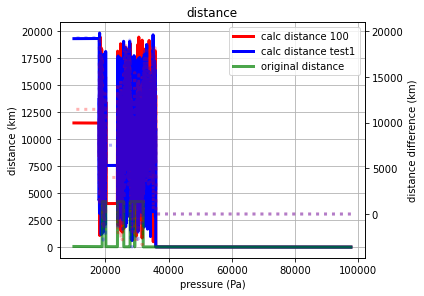

----------------
-14.340000000000002 -170.72000000000003 19201130.0 230100.0


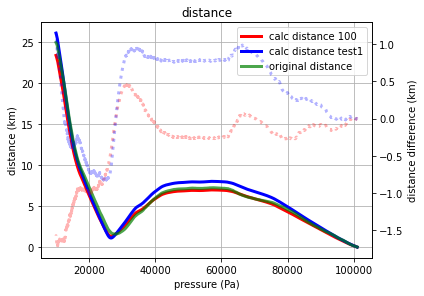

----------------
40.77 -111.96000000000001 19201130.0 230600.0


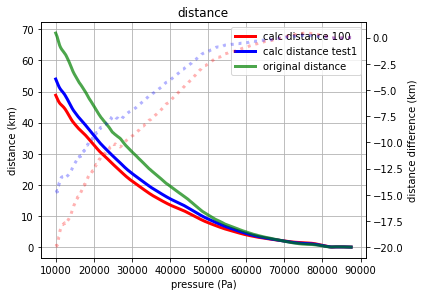

----------------
33.36 -84.57000000000001 19201130.0 231000.0


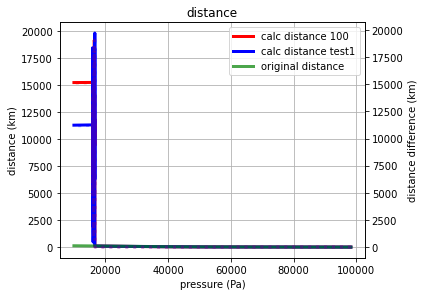

----------------
48.21 -106.63000000000001 19201130.0 230100.0


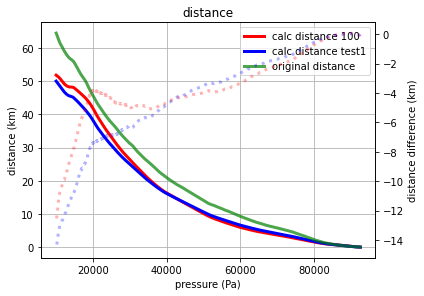

----------------
46.77 -100.76 19201130.0 230800.0


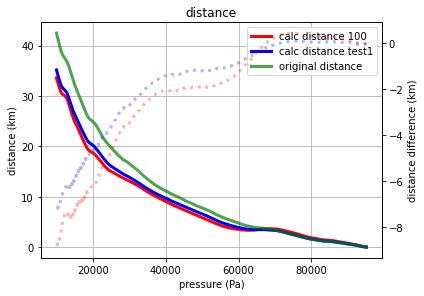

----------------
32.230000000000004 -110.96000000000001 19201130.0 230300.0


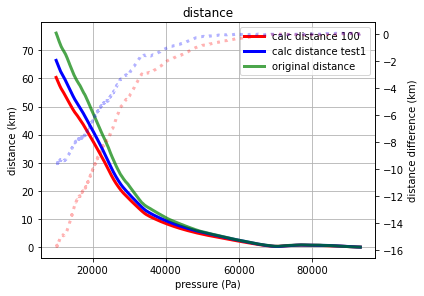

----------------
35.230000000000004 -111.82000000000001 19201130.0 231900.0


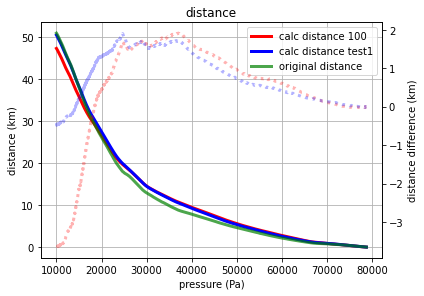

----------------
32.84 -97.30000000000001 19201130.0 230900.0


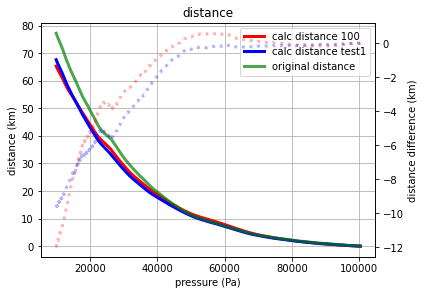

----------------


In [17]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()